<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_rawit_hijau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f51865d4550>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_rawit_hijau.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


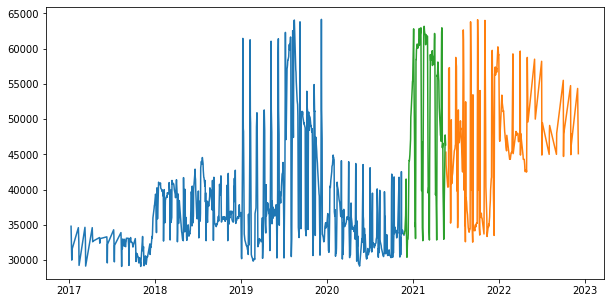

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabairawithijau_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 47ms/step - loss: 0.0329 - mae: 0.1431 - mape: 88.8170 - val_loss: 0.3990 - val_mae: 0.5753 - val_mape: 90.3158
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0264 - mae: 0.1198 - mape: 73.6391 - val_loss: 0.3727 - val_mae: 0.5519 - val_mape: 84.3985
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0216 - mae: 0.1047 - mape: 81.0100 - val_loss: 0.3504 - val_mae: 0.5320 - val_mape: 79.9378
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0183 - mae: 0.0965 - mape: 96.9031 - val_loss: 0.3326 - val_mae: 0.5168 - val_mape: 78.0303
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0162 - mae: 0.0918 - mape: 105.6717 - val_loss: 0.3184 - val_mae: 0.5042 - val_mape: 76.4608
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0148 - mae: 0.0887 - mape: 116.2505 - val_loss: 0.3082 - val_mae: 0.4951 - val_mape: 75.

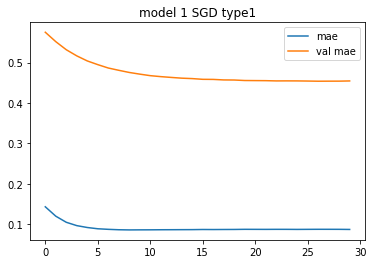

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
10572.014 21.026718 13172.897023813706


,date,actual,prediction
0,2021-05-20,45300,34455.601562
1,2021-05-21,43500,34443.585938
2,2021-05-24,42100,34445.300781
3,2021-05-25,41450,34457.878906
4,2021-05-27,40750,34446.687500
...,...,...,...
229,2022-11-02,44950,34945.082031
230,2022-11-03,47900,34892.683594
231,2022-11-04,46350,34938.035156
232,2022-12-01,54350,34897.496094


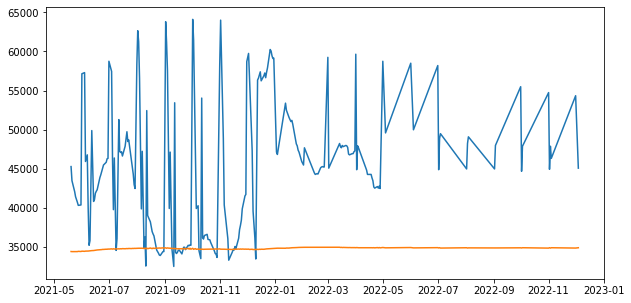

In [ ]:
prediction = forecast_predict(model, test_cabairawithijau_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabairawithijau = pd.DataFrame()
data_new_cabairawithijau['date'] = y_test
data_new_cabairawithijau['actual'] = x_test
data_new_cabairawithijau['prediction'] = data_result
data_new_cabairawithijau.to_csv('cabairawithijau_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabairawithijau.date, data_new_cabairawithijau.actual)
plt.plot(data_new_cabairawithijau.date, data_new_cabairawithijau.prediction)
data_new_cabairawithijau

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0411 - mae: 0.1510 - mape: 154.7055 - val_loss: 0.1975 - val_mae: 0.3886 - val_mape: 66.6393
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0387 - mae: 0.1482 - mape: 148.9532 - val_loss: 0.1936 - val_mae: 0.3845 - val_mape: 66.4492
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0382 - mae: 0.1473 - mape: 159.3396 - val_loss: 0.1848 - val_mae: 0.3748 - val_mape: 65.9901
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0378 - mae: 0.1463 - mape: 154.8354 - val_loss: 0.1815 - val_mae: 0.3714 - val_mape: 65.8986
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0373 - mae: 0.1448 - mape: 152.4923 - val_loss: 0.1747 - val_mae: 0.3640 - val_mape: 65.6585
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0368 - mae: 0.1442 - mape: 153.3743 - val_loss: 0.1689 - val_mae: 0.3576 - val_

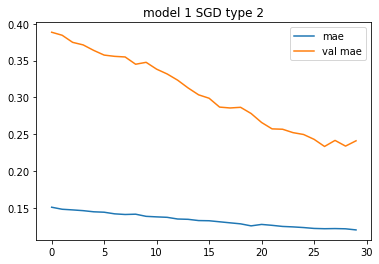

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6972.7363 14.21621 9350.340742454255


,date,actual,prediction
0,2021-05-20,45300,34455.601562
1,2021-05-21,43500,34443.585938
2,2021-05-24,42100,34445.300781
3,2021-05-25,41450,34457.878906
4,2021-05-27,40750,34446.687500
...,...,...,...
229,2022-11-02,44950,34945.082031
230,2022-11-03,47900,34892.683594
231,2022-11-04,46350,34938.035156
232,2022-12-01,54350,34897.496094


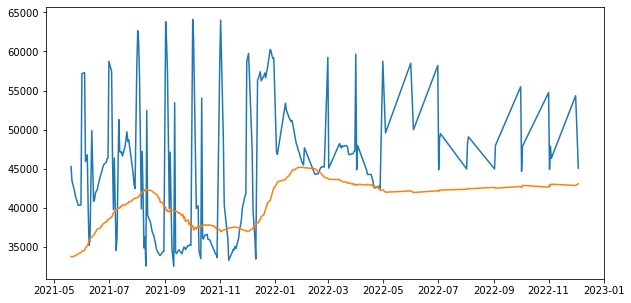

In [ ]:
win_size1 = 60
test_cabairawithijau_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabairawithijau_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabairawithijau_1 = pd.DataFrame()
data_new_cabairawithijau_1['actual'] = x_test
data_new_cabairawithijau_1['prediction'] = data_result_1
data_new_cabairawithijau_1.to_csv('cabairawithijau_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawithijau_1.actual)
plt.plot(y_test, data_new_cabairawithijau_1.prediction)
data_new_cabairawithijau

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 2s 16ms/step - loss: 0.0394 - mae: 0.1394 - mape: 129.3821 - val_loss: 0.0761 - val_mae: 0.2264 - val_mape: 70.5269
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0380 - mae: 0.1428 - mape: 151.8622 - val_loss: 0.0737 - val_mae: 0.2234 - val_mape: 71.8056
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0377 - mae: 0.1431 - mape: 153.6964 - val_loss: 0.0733 - val_mae: 0.2231 - val_mape: 72.0763
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0377 - mae: 0.1429 - mape: 153.2524 - val_loss: 0.0730 - val_mae: 0.2229 - val_mape: 72.4093
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0375 - mae: 0.1438 - mape: 158.5107 - val_loss: 0.0725 - val_mae: 0.2227 - val_mape: 72.7847
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0375 - mae: 0.1416 - mape: 151.3418 - val_loss: 0.0723 - val_mae: 0.2226 - val_mape: 

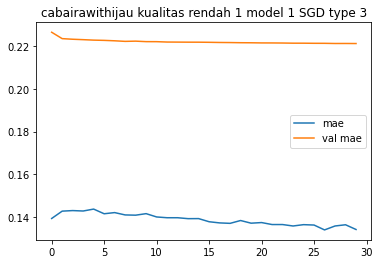

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabairawithijau kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
6358.2046 13.650229 8354.242515033904


,actual,prediction
0,45300,34561.660156
1,43500,34500.378906
2,42100,34671.992188
3,41450,34765.003906
4,40750,34939.164062
...,...,...
229,44950,46587.652344
230,47900,46402.750000
231,46350,46678.855469
232,54350,46486.000000


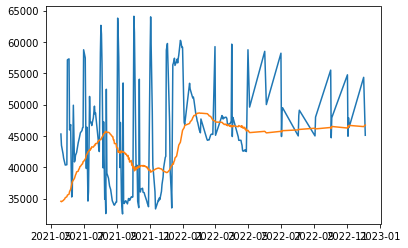

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabairawithijau_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabairawithijau_2 = pd.DataFrame()
# data_new_cabairawithijau1['date'] = date_test
data_new_cabairawithijau_2['actual'] = x_test
data_new_cabairawithijau_2['prediction'] = data_result_2
data_new_cabairawithijau_2.to_csv('cabairawithijau_model1_sgd_type3')

plt.plot(y_test, data_new_cabairawithijau_2.actual)
plt.plot(y_test, data_new_cabairawithijau_2.prediction)
data_new_cabairawithijau_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 37ms/step - loss: 0.0322 - mae: 0.1395 - mape: 89.9575 - val_loss: 0.3584 - val_mae: 0.5387 - val_mape: 81.0902
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0191 - mae: 0.0982 - mape: 86.5673 - val_loss: 0.2442 - val_mae: 0.4357 - val_mape: 69.5561
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0118 - mae: 0.0805 - mape: 147.8554 - val_loss: 0.1584 - val_mae: 0.3474 - val_mape: 65.9385
Epoch 4/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0107 - mae: 0.0797 - mape: 167.8027 - val_loss: 0.1500 - val_mae: 0.3385 - val_mape: 66.0982
Epoch 5/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0105 - mae: 0.0776 - mape: 159.5672 - val_loss: 0.1508 - val_mae: 0.3394 - val_mape: 66.0886
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0104 - mae: 0.0775 - mape: 160.7202 - val_loss: 0.1430 - val_mae: 0.3307 - val_mape: 66

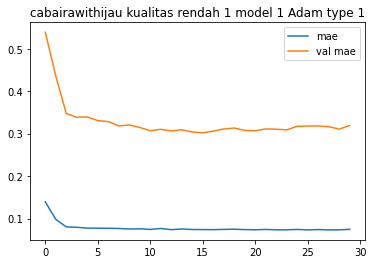

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabairawithijau kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
8452.318 17.125124 10629.527553000651


,actual,prediction
0,45300,33325.457031
1,43500,33335.800781
2,42100,33409.585938
3,41450,33498.351562
4,40750,33570.769531
...,...,...
229,44950,40576.261719
230,47900,40545.359375
231,46350,40570.164062
232,54350,40538.023438


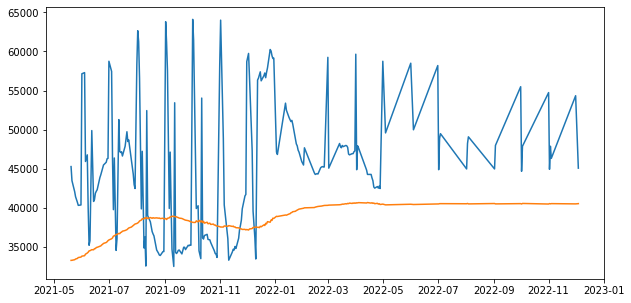

In [ ]:
prediction_a = forecast_predict(model_a, test_cabairawithijau_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabairawithijau_a = pd.DataFrame()
# data_new_cabairawithijau1['date'] = date_test
data_new_cabairawithijau_a['actual'] = x_test
data_new_cabairawithijau_a['prediction'] = data_result_a
data_new_cabairawithijau_a.to_csv('cabairawithijau_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabairawithijau_a.actual)
plt.plot(y_test, data_new_cabairawithijau_a.prediction)
data_new_cabairawithijau_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0293 - mae: 0.1218 - mape: 116.4433 - val_loss: 0.0859 - val_mae: 0.2476 - val_mape: 68.9814
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0286 - mae: 0.1219 - mape: 115.8605 - val_loss: 0.0750 - val_mae: 0.2254 - val_mape: 71.5619
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0281 - mae: 0.1189 - mape: 111.4130 - val_loss: 0.0838 - val_mae: 0.2465 - val_mape: 69.9651
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0279 - mae: 0.1178 - mape: 116.3255 - val_loss: 0.0800 - val_mae: 0.2384 - val_mape: 70.5545
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0276 - mae: 0.1165 - mape: 111.6322 - val_loss: 0.0711 - val_mae: 0.2190 - val_mape: 73.7485
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0276 - mae: 0.1165 - mape: 111.1072 - val_loss: 0.0709 - val_mae: 0.2189 - val_

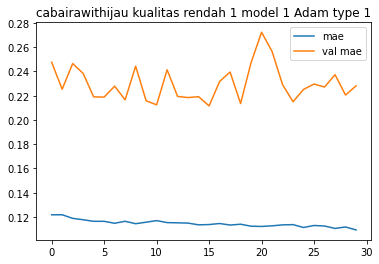

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabairawithijau kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6337.1987 14.0546055 8110.461639142373


,actual,prediction
0,45300,35086.832031
1,43500,34867.144531
2,42100,35710.218750
3,41450,35376.429688
4,40750,36239.960938
...,...,...
229,44950,47453.863281
230,47900,47661.558594
231,46350,47235.332031
232,54350,47896.265625


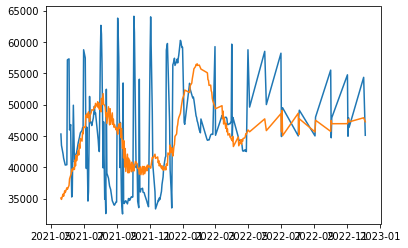

In [ ]:
prediction_a1 = forecast_predict(model_a, test_cabairawithijau_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabairawithijau_a1 = pd.DataFrame()
data_new_cabairawithijau_a1['actual'] = x_test
data_new_cabairawithijau_a1['prediction'] = data_result_a1
data_new_cabairawithijau_a1.to_csv('cabairawithijau_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabairawithijau_a1.actual)
plt.plot(y_test, data_new_cabairawithijau_a1.prediction)
data_new_cabairawithijau_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0299 - mae: 0.1223 - mape: 129.1869 - val_loss: 0.0691 - val_mae: 0.2173 - val_mape: 62.7294
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0298 - mae: 0.1224 - mape: 130.3248 - val_loss: 0.0654 - val_mae: 0.2110 - val_mape: 63.5199
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0295 - mae: 0.1202 - mape: 128.2733 - val_loss: 0.0661 - val_mae: 0.2121 - val_mape: 62.6769
Epoch 4/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0292 - mae: 0.1212 - mape: 129.5513 - val_loss: 0.0668 - val_mae: 0.2132 - val_mape: 61.9363
Epoch 5/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0290 - mae: 0.1192 - mape: 125.1079 - val_loss: 0.0680 - val_mae: 0.2150 - val_mape: 60.9196
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0289 - mae: 0.1200 - mape: 128.3476 - val_loss: 0.0699 - val_mae: 0.2186 - val_mape: 

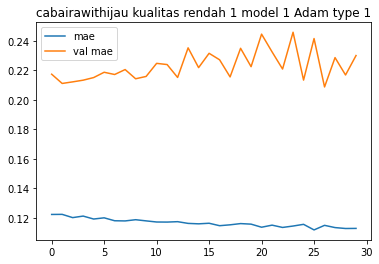

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabairawithijau kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
7074.347 15.638518 9037.73777003958


,actual,prediction
0,45300,34130.894531
1,43500,33741.617188
2,42100,35090.007812
3,41450,34398.414062
4,40750,35605.937500
...,...,...
229,44950,42058.789062
230,47900,40165.914062
231,46350,40937.054688
232,54350,40985.433594


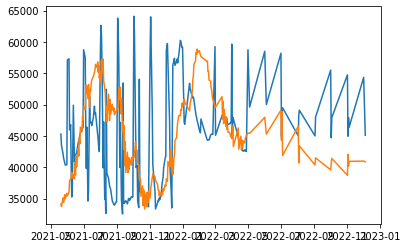

In [ ]:
prediction_a2 = forecast_predict(model_a, test_cabairawithijau_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabairawithijau_a2 = pd.DataFrame()
# data_new_cabairawithijau1['date'] = date_test
data_new_cabairawithijau_a2['actual'] = x_test
data_new_cabairawithijau_a2['prediction'] = data_result_a2
data_new_cabairawithijau_a2.to_csv('cabairawithijau_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabairawithijau_a2.actual)
plt.plot(y_test, data_new_cabairawithijau_a2.prediction)
data_new_cabairawithijau_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.0202 - mae: 0.1030 - mape: 121.1192 - val_loss: 0.0952 - val_mae: 0.2638 - val_mape: 67.3801
Epoch 2/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0788 - mape: 169.5698 - val_loss: 0.1068 - val_mae: 0.2835 - val_mape: 67.0178
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0106 - mae: 0.0772 - mape: 159.1636 - val_loss: 0.0880 - val_mae: 0.2504 - val_mape: 67.8575
Epoch 4/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0106 - mae: 0.0776 - mape: 167.2642 - val_loss: 0.1089 - val_mae: 0.2867 - val_mape: 66.8824
Epoch 5/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0107 - mae: 0.0776 - mape: 152.2162 - val_loss: 0.0975 - val_mae: 0.2678 - val_mape: 67.2038
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0104 - mae: 0.0765 - mape: 164.2071 - val_loss: 0.0951 - val_mae: 0.2632 - val_mape: 

17/17 [==============================] - 0s 7ms/step - loss: 0.0597 - mae: 0.1843 - mape: 31.5840


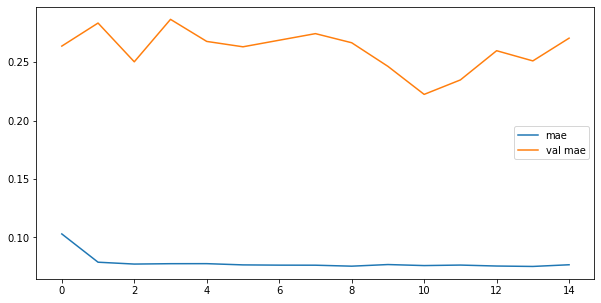

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_cabairawithijau_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabairawithijau1 = pd.DataFrame()
data_new_cabairawithijau1['actual'] = x_test
data_new_cabairawithijau1['prediction'] = data_result1
data_new_cabairawithijau1.to_csv('cabairawithijau_model2_adam_type1.csv')

data_new_cabairawithijau1

131/131 [==============================] - 2s 7ms/step
8105.449 16.443058 10344.979458655294


,actual,prediction
0,45300,33517.343750
1,43500,33600.585938
2,42100,33610.027344
3,41450,33688.007812
4,40750,33735.164062
...,...,...
229,44950,40792.035156
230,47900,40913.777344
231,46350,40813.253906
232,54350,40936.031250


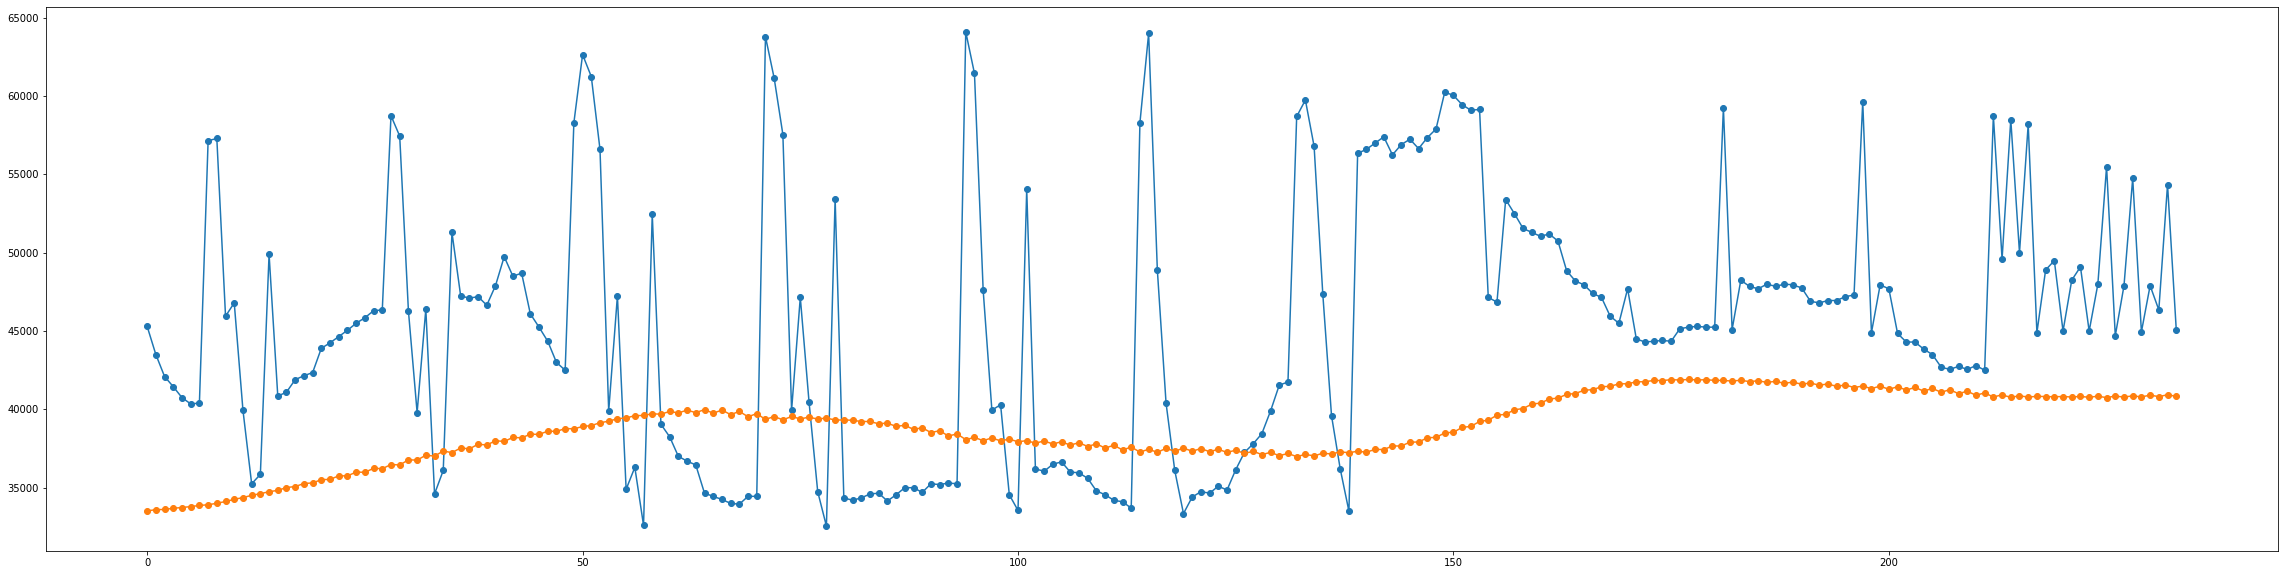

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabairawithijau1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabairawithijau1['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 23s 13ms/step - loss: 0.0322 - mae: 0.1327 - mape: 118.6946 - val_loss: 0.0883 - val_mae: 0.2522 - val_mape: 68.7120
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0289 - mae: 0.1222 - mape: 117.5789 - val_loss: 0.0695 - val_mae: 0.2181 - val_mape: 76.6207
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0286 - mae: 0.1190 - mape: 113.7756 - val_loss: 0.0835 - val_mae: 0.2434 - val_mape: 69.8290
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0294 - mae: 0.1232 - mape: 113.5051 - val_loss: 0.0774 - val_mae: 0.2292 - val_mape: 71.0243
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0281 - mae: 0.1185 - mape: 110.7512 - val_loss: 0.0701 - val_mae: 0.2174 - val_mape: 75.9533
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0280 - mae: 0.1181 - mape: 111.9342 - val_loss: 0.0728 - val_mae: 0.2200 - va

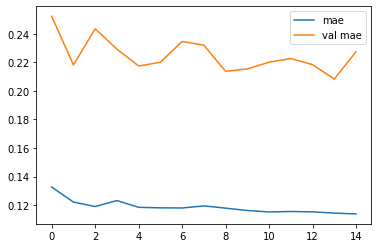

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 6ms/step
6884.2725 14.091285 9307.577128340114


,actual,prediction
0,45300,35483.804688
1,43500,35484.507812
2,42100,35432.062500
3,41450,35565.765625
4,40750,35243.996094
...,...,...
229,44950,41648.265625
230,47900,42135.417969
231,46350,41899.160156
232,54350,42814.039062


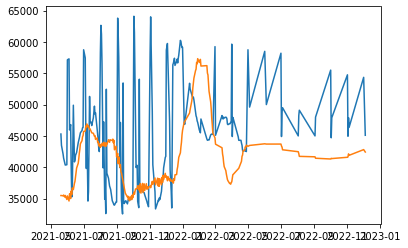

In [14]:
prediction1_1 = forecast_predict(model1, test_cabairawithijau_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabairawithijau1_1 = pd.DataFrame()
data_new_cabairawithijau1_1['actual'] = x_test
data_new_cabairawithijau1_1['prediction'] = data_result1_1
data_new_cabairawithijau1_1.to_csv('cabairawithijau_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabairawithijau1_1.actual)
plt.plot(y_test, data_new_cabairawithijau1_1.prediction)
data_new_cabairawithijau1_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 17s 33ms/step - loss: 0.0653 - mae: 0.1819 - mape: 152.7885 - val_loss: 0.0820 - val_mae: 0.2378 - val_mape: 68.5517
Epoch 2/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0393 - mae: 0.1467 - mape: 163.8591 - val_loss: 0.0689 - val_mae: 0.2179 - val_mape: 75.4828
Epoch 3/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0378 - mae: 0.1387 - mape: 148.2605 - val_loss: 0.0672 - val_mae: 0.2153 - val_mape: 78.7266
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0362 - mae: 0.1352 - mape: 142.2940 - val_loss: 0.0706 - val_mae: 0.2154 - val_mape: 88.8424
Epoch 5/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0356 - mae: 0.1335 - mape: 144.6329 - val_loss: 0.0660 - val_mae: 0.2110 - val_mape: 78.1895
Epoch 6/15
84/84 [==============================] - 2s 16ms/step - loss: 0.0348 - mae: 0.1342 - mape: 140.0778 - val_loss: 0.0836 - val_mae: 0.2187 - val_mape:

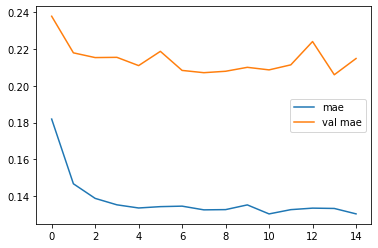

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 5ms/step
6327.7793 13.68732 8526.477819123205


,actual,prediction
0,45300,34487.281250
1,43500,34976.472656
2,42100,34758.070312
3,41450,35174.761719
4,40750,35160.035156
...,...,...
229,44950,43741.656250
230,47900,44520.554688
231,46350,43802.945312
232,54350,44628.035156


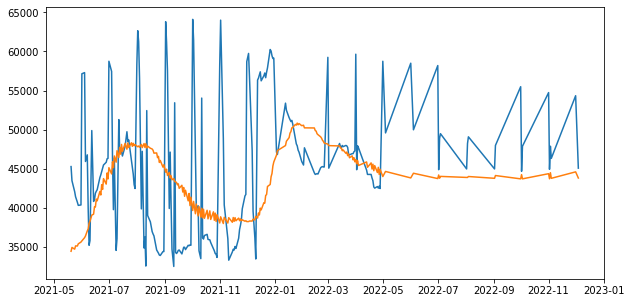

In [ ]:
prediction1_2 = forecast_predict(model1, test_cabairawithijau_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabairawithijau1_2 = pd.DataFrame()
data_new_cabairawithijau1_2['actual'] = x_test
data_new_cabairawithijau1_2['prediction'] = data_result1_2
data_new_cabairawithijau1_2.to_csv('cabairawithijau_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawithijau1_2.actual)
plt.plot(y_test, data_new_cabairawithijau1_2.prediction)

data_new_cabairawithijau1_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 48ms/step - loss: 0.0354 - mae: 0.1500 - mape: 92.0464 - val_loss: 0.4345 - val_mae: 0.6055 - val_mape: 98.0962
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0282 - mae: 0.1247 - mape: 76.1492 - val_loss: 0.4039 - val_mae: 0.5797 - val_mape: 91.5608
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0231 - mae: 0.1090 - mape: 79.4016 - val_loss: 0.3805 - val_mae: 0.5591 - val_mape: 86.3565
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0197 - mae: 0.0997 - mape: 88.5241 - val_loss: 0.3606 - val_mae: 0.5411 - val_mape: 81.7759
Epoch 5/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0174 - mae: 0.0942 - mape: 100.5294 - val_loss: 0.3450 - val_mae: 0.5274 - val_mape: 79.3908
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0158 - mae: 0.0906 - mape: 112.1193 - val_loss: 0.3323 - val_mae: 0.5166 - val_mape: 78.0

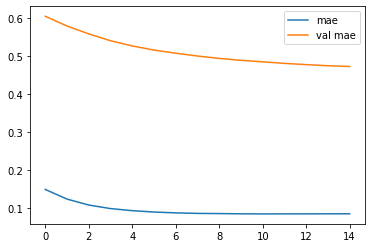

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
10950.867 21.819601 13561.7161155954


,actual,prediction
0,45300,34180.535156
1,43500,34201.851562
2,42100,34188.019531
3,41450,34203.128906
4,40750,34189.324219
...,...,...
229,44950,34358.242188
230,47900,34287.921875
231,46350,34345.863281
232,54350,34297.289062


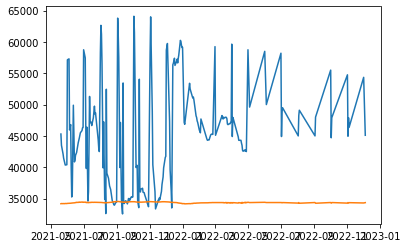

In [ ]:
prediction1_a = forecast_predict(model1_a, test_cabairawithijau_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabairawithijau1_a = pd.DataFrame()
data_new_cabairawithijau1_a['actual'] = x_test
data_new_cabairawithijau1_a['prediction'] = data_result1_a
data_new_cabairawithijau1_a.to_csv('cabairawithijau_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabairawithijau1_a.actual)
plt.plot(y_test, data_new_cabairawithijau1_a.prediction)

data_new_cabairawithijau1_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0414 - mae: 0.1504 - mape: 145.0104 - val_loss: 0.1932 - val_mae: 0.3841 - val_mape: 66.4056
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0380 - mae: 0.1456 - mape: 155.2499 - val_loss: 0.1778 - val_mae: 0.3672 - val_mape: 65.7321
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0368 - mae: 0.1433 - mape: 152.2264 - val_loss: 0.1737 - val_mae: 0.3628 - val_mape: 65.6346
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0360 - mae: 0.1430 - mape: 149.4822 - val_loss: 0.1694 - val_mae: 0.3580 - val_mape: 65.5186
Epoch 5/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0356 - mae: 0.1403 - mape: 147.3420 - val_loss: 0.1540 - val_mae: 0.3424 - val_mape: 65.8029
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0348 - mae: 0.1398 - mape: 144.7709 - val_loss: 0.1472 - val_mae: 0.3351 - val

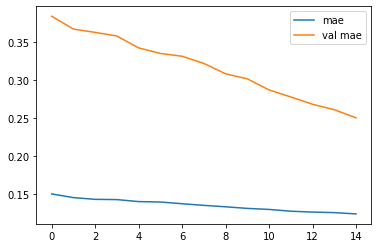

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6921.657 14.222821 9176.96594741421


,actual,prediction
0,45300,34596.011719
1,43500,34660.238281
2,42100,34659.816406
3,41450,34705.191406
4,40750,34775.636719
...,...,...
229,44950,42740.656250
230,47900,43136.437500
231,46350,42807.023438
232,54350,43208.515625


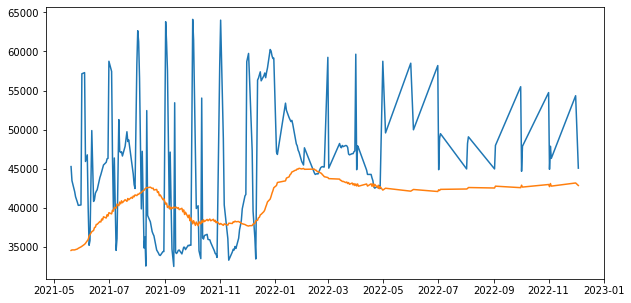

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_cabairawithijau_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabairawithijau1_a1 = pd.DataFrame()
data_new_cabairawithijau1_a1['actual'] = x_test
data_new_cabairawithijau1_a1['prediction'] = data_result1_a1
data_new_cabairawithijau1_a1.to_csv('cabairawithijau_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawithijau1_a1.actual)
plt.plot(y_test, data_new_cabairawithijau1_a1.prediction)
data_new_cabairawithijau1_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0394 - mae: 0.1431 - mape: 139.9383 - val_loss: 0.0812 - val_mae: 0.2356 - val_mape: 68.3625
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0386 - mae: 0.1473 - mape: 159.4596 - val_loss: 0.0793 - val_mae: 0.2314 - val_mape: 68.7054
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0383 - mae: 0.1474 - mape: 161.5107 - val_loss: 0.0785 - val_mae: 0.2301 - val_mape: 68.9638
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0382 - mae: 0.1466 - mape: 160.8985 - val_loss: 0.0781 - val_mae: 0.2293 - val_mape: 69.1138
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0380 - mae: 0.1447 - mape: 155.6616 - val_loss: 0.0774 - val_mae: 0.2284 - val_mape: 69.3568
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0378 - mae: 0.1455 - mape: 159.8078 - val_loss: 0.0767 - val_mae: 0.2273 - val_mape: 

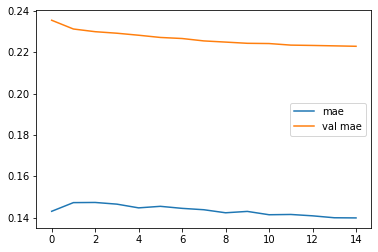

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
6366.8916 13.6459055 8376.379647556574


,actual,prediction
0,45300,35070.773438
1,43500,35198.355469
2,42100,35193.757812
3,41450,35297.628906
4,40750,35407.886719
...,...,...
229,44950,45600.265625
230,47900,46011.593750
231,46350,45677.132812
232,54350,46085.808594


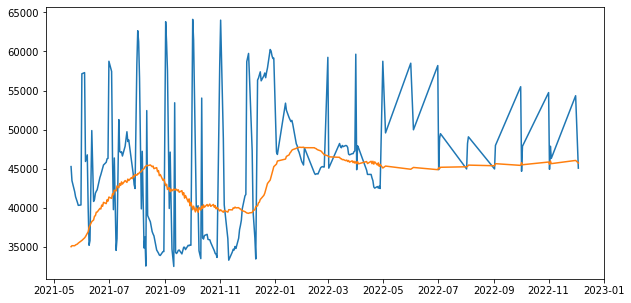

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_cabairawithijau_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabairawithijau1_a2 = pd.DataFrame()
data_new_cabairawithijau1_a2['actual'] = x_test
data_new_cabairawithijau1_a2['prediction'] = data_result1_a2
data_new_cabairawithijau1_a2.to_csv('cabairawithijau_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawithijau1_a2.actual)
plt.plot(y_test, data_new_cabairawithijau1_a2.prediction)

data_new_cabairawithijau1_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.0341 - mae: 0.1460 - mape: 87.1515 - val_loss: 0.4170 - val_mae: 0.5907 - val_mape: 94.1731
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0280 - mae: 0.1242 - mape: 76.9566 - val_loss: 0.3908 - val_mae: 0.5681 - val_mape: 88.4379
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0234 - mae: 0.1098 - mape: 77.7628 - val_loss: 0.3710 - val_mae: 0.5503 - val_mape: 83.9489
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0203 - mae: 0.1010 - mape: 87.1568 - val_loss: 0.3540 - val_mae: 0.5349 - val_mape: 80.3859
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0180 - mae: 0.0955 - mape: 95.8199 - val_loss: 0.3404 - val_mae: 0.5235 - val_mape: 78.9537
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0164 - mae: 0.0922 - mape: 105.5584 - val_loss: 0.3291 - val_mae: 0.5138 - val_mape: 77.73

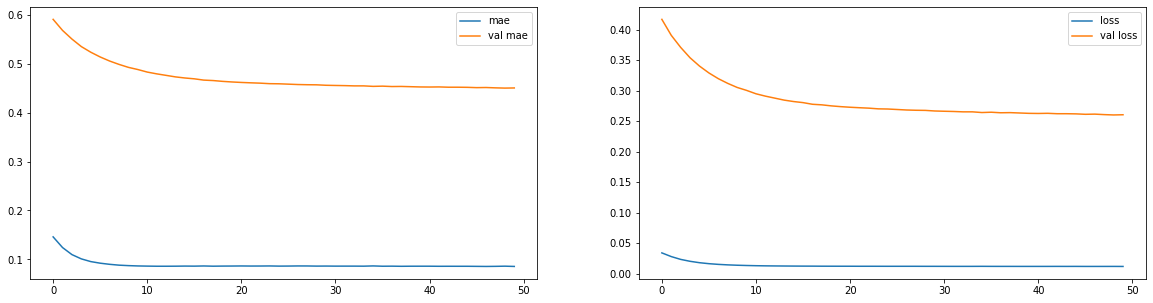

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
10461.5205 20.813377 13037.37028698656


,actual,prediction
0,45300,34309.199219
1,43500,34355.875000
2,42100,34355.300781
3,41450,34373.398438
4,40750,34337.964844
...,...,...
229,44950,35178.902344
230,47900,35192.394531
231,46350,35194.339844
232,54350,35178.585938


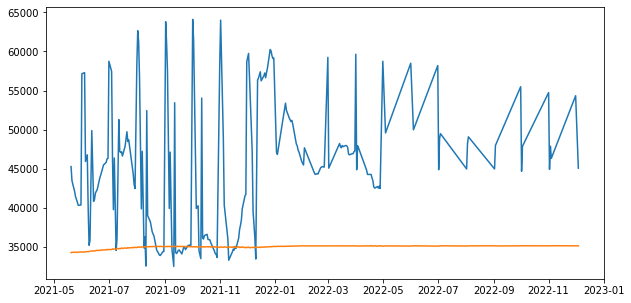

In [ ]:
prediction2 = forecast_predict(model2, test_cabairawithijau_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabairawithijau2 = pd.DataFrame()
data_new_cabairawithijau2['actual'] = x_test
data_new_cabairawithijau2['prediction'] = data_result2
data_new_cabairawithijau2.to_csv('cabairawithijau_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabairawithijau2.actual)
plt.plot(y_test, data_new_cabairawithijau2.prediction)
data_new_cabairawithijau2

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0423 - mae: 0.1522 - mape: 146.3369 - val_loss: 0.1927 - val_mae: 0.3833 - val_mape: 66.3788
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0395 - mae: 0.1495 - mape: 153.5268 - val_loss: 0.1901 - val_mae: 0.3803 - val_mape: 66.2327
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0391 - mae: 0.1485 - mape: 153.6436 - val_loss: 0.1844 - val_mae: 0.3741 - val_mape: 65.9119
Epoch 4/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0391 - mae: 0.1484 - mape: 158.6177 - val_loss: 0.1848 - val_mae: 0.3745 - val_mape: 65.9340
Epoch 5/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0387 - mae: 0.1481 - mape: 154.2838 - val_loss: 0.1823 - val_mae: 0.3718 - val_mape: 65.8430
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0386 - mae: 0.1475 - mape: 151.3048 - val_loss: 0.1820 - val_mae: 0.3714 - val_

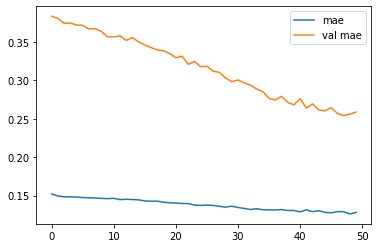

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_cabairawithijau_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabairawithijau2_1 = pd.DataFrame()
data_new_cabairawithijau2_1['actual'] = x_test
data_new_cabairawithijau2_1['prediction'] = data_result2_1
data_new_cabairawithijau2_1.to_csv('cabairawithijau_model3_sgd_type2.csv')

data_new_cabairawithijau2

199/199 [==============================] - 1s 3ms/step
7924.5913 16.228905 10014.820218056837


,actual,prediction
0,45300,34309.199219
1,43500,34355.875000
2,42100,34355.300781
3,41450,34373.398438
4,40750,34337.964844
...,...,...
229,44950,35178.902344
230,47900,35192.394531
231,46350,35194.339844
232,54350,35178.585938


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0427 - mae: 0.1453 - mape: 133.5925 - val_loss: 0.0863 - val_mae: 0.2448 - val_mape: 67.7019
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0413 - mae: 0.1485 - mape: 154.4249 - val_loss: 0.0832 - val_mae: 0.2386 - val_mape: 68.0797
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0409 - mae: 0.1502 - mape: 161.9540 - val_loss: 0.0829 - val_mae: 0.2380 - val_mape: 68.1140
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0414 - mae: 0.1515 - mape: 164.3749 - val_loss: 0.0820 - val_mae: 0.2362 - val_mape: 68.2496
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0412 - mae: 0.1513 - mape: 163.4423 - val_loss: 0.0818 - val_mae: 0.2357 - val_mape: 68.2977
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0412 - mae: 0.1491 - mape: 159.9515 - val_loss: 0.0814 - val_mae: 0.2349 - val_mape: 

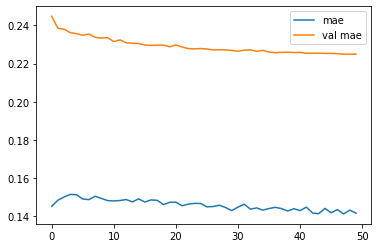

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_cabairawithijau_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabairawithijau2_2 = pd.DataFrame()
data_new_cabairawithijau2_2['actual'] = x_test
data_new_cabairawithijau2_2['prediction'] = data_result2_2
data_new_cabairawithijau2_2.to_csv('cabairawithijau_model3_sgd-type3.csv')

data_new_cabairawithijau2_2

181/181 [==============================] - 1s 4ms/step
6805.0923 14.640963 8691.395284993083


,actual,prediction
0,45300,34248.980469
1,43500,34407.312500
2,42100,34344.636719
3,41450,34470.613281
4,40750,34761.257812
...,...,...
229,44950,45049.582031
230,47900,45184.597656
231,46350,44981.234375
232,54350,45449.460938


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.0283 - mae: 0.1254 - mape: 75.7793 - val_loss: 0.3018 - val_mae: 0.4890 - val_mape: 74.6247
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 0.0124 - mae: 0.0856 - mape: 167.5384 - val_loss: 0.1994 - val_mae: 0.3898 - val_mape: 66.8607
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0103 - mae: 0.0767 - mape: 150.5917 - val_loss: 0.1971 - val_mae: 0.3872 - val_mape: 66.7148
Epoch 4/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0103 - mae: 0.0775 - mape: 165.4872 - val_loss: 0.1885 - val_mae: 0.3776 - val_mape: 66.1612
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0102 - mae: 0.0775 - mape: 163.2060 - val_loss: 0.1899 - val_mae: 0.3792 - val_mape: 66.2585
Epoch 6/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0100 - mae: 0.0763 - mape: 160.4287 - val_loss: 0.1822 - val_mae: 0.3702 - val_mape: 6

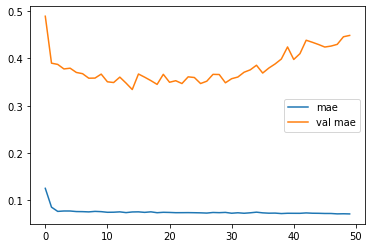

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_cabairawithijau_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabairawithijau2_a = pd.DataFrame()
data_new_cabairawithijau2_a['actual'] = x_test
data_new_cabairawithijau2_a['prediction'] = data_result2_a
data_new_cabairawithijau2_a.to_csv('cabairawithijau_model3_adam-type1.csv')

data_new_cabairawithijau2_a

131/131 [==============================] - 1s 6ms/step
10421.637 20.946484 12796.763965940765


,actual,prediction
0,45300,33156.484375
1,43500,33175.167969
2,42100,33151.312500
3,41450,33214.691406
4,40750,33097.441406
...,...,...
229,44950,37345.175781
230,47900,37233.453125
231,46350,37285.429688
232,54350,37130.171875


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0318 - mae: 0.1300 - mape: 119.2103 - val_loss: 0.0729 - val_mae: 0.2219 - val_mape: 70.9072
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0303 - mae: 0.1260 - mape: 121.2567 - val_loss: 0.0672 - val_mae: 0.2135 - val_mape: 73.6491
Epoch 3/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0289 - mae: 0.1225 - mape: 119.6320 - val_loss: 0.0805 - val_mae: 0.2437 - val_mape: 68.3498
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0284 - mae: 0.1201 - mape: 114.4393 - val_loss: 0.0879 - val_mae: 0.2583 - val_mape: 67.7796
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0293 - mae: 0.1214 - mape: 118.7027 - val_loss: 0.0703 - val_mae: 0.2182 - val_mape: 70.1277
Epoch 6/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0288 - mae: 0.1213 - mape: 125.1870 - val_loss: 0.0653 - val_mae: 0.2079 - val_

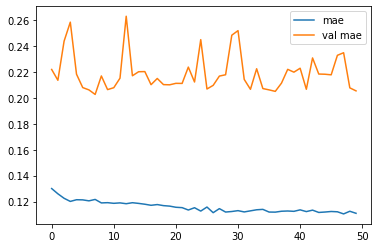

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
7087.409 16.49922 8593.866184669156


,actual,prediction
0,45300,33450.617188
1,43500,33515.039062
2,42100,34287.105469
3,41450,34538.824219
4,40750,34280.867188
...,...,...
229,44950,48942.296875
230,47900,50410.660156
231,46350,49543.093750
232,54350,50487.464844


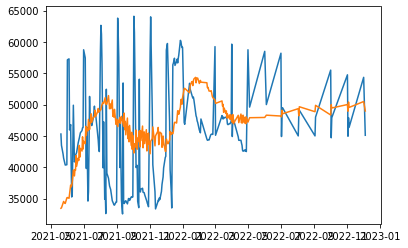

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_cabairawithijau_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabairawithijau2_a1 = pd.DataFrame()
data_new_cabairawithijau2_a1['actual'] = x_test
data_new_cabairawithijau2_a1['prediction'] = data_result2_a1
data_new_cabairawithijau2_a1.to_csv('cabairawithijau_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabairawithijau2_a1.actual)
plt.plot(y_test, data_new_cabairawithijau2_a1.prediction)
data_new_cabairawithijau2_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 3s 31ms/step - loss: 0.0304 - mae: 0.1245 - mape: 127.7020 - val_loss: 0.0979 - val_mae: 0.2714 - val_mape: 66.7372
Epoch 2/50
84/84 [==============================] - 3s 30ms/step - loss: 0.0313 - mae: 0.1248 - mape: 119.2437 - val_loss: 0.0937 - val_mae: 0.2643 - val_mape: 67.0155
Epoch 3/50
84/84 [==============================] - 1s 14ms/step - loss: 0.0309 - mae: 0.1253 - mape: 127.6343 - val_loss: 0.0996 - val_mae: 0.2741 - val_mape: 66.6921
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0311 - mae: 0.1238 - mape: 111.8009 - val_loss: 0.0987 - val_mae: 0.2727 - val_mape: 66.7540
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0308 - mae: 0.1265 - mape: 124.9385 - val_loss: 0.0937 - val_mae: 0.2643 - val_mape: 67.0036
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0301 - mae: 0.1221 - mape: 117.4800 - val_loss: 0.0930 - val_mae: 0.2629 - val_mape: 

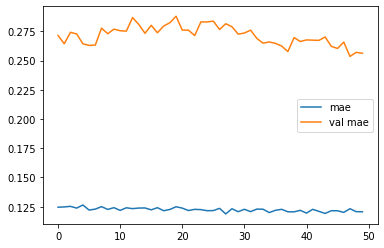

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
8969.03 20.371872 10868.353325136242


,actual,prediction
0,45300,34027.773438
1,43500,34120.910156
2,42100,34183.042969
3,41450,34162.792969
4,40750,34346.355469
...,...,...
229,44950,41267.843750
230,47900,41395.167969
231,46350,40790.046875
232,54350,41240.519531


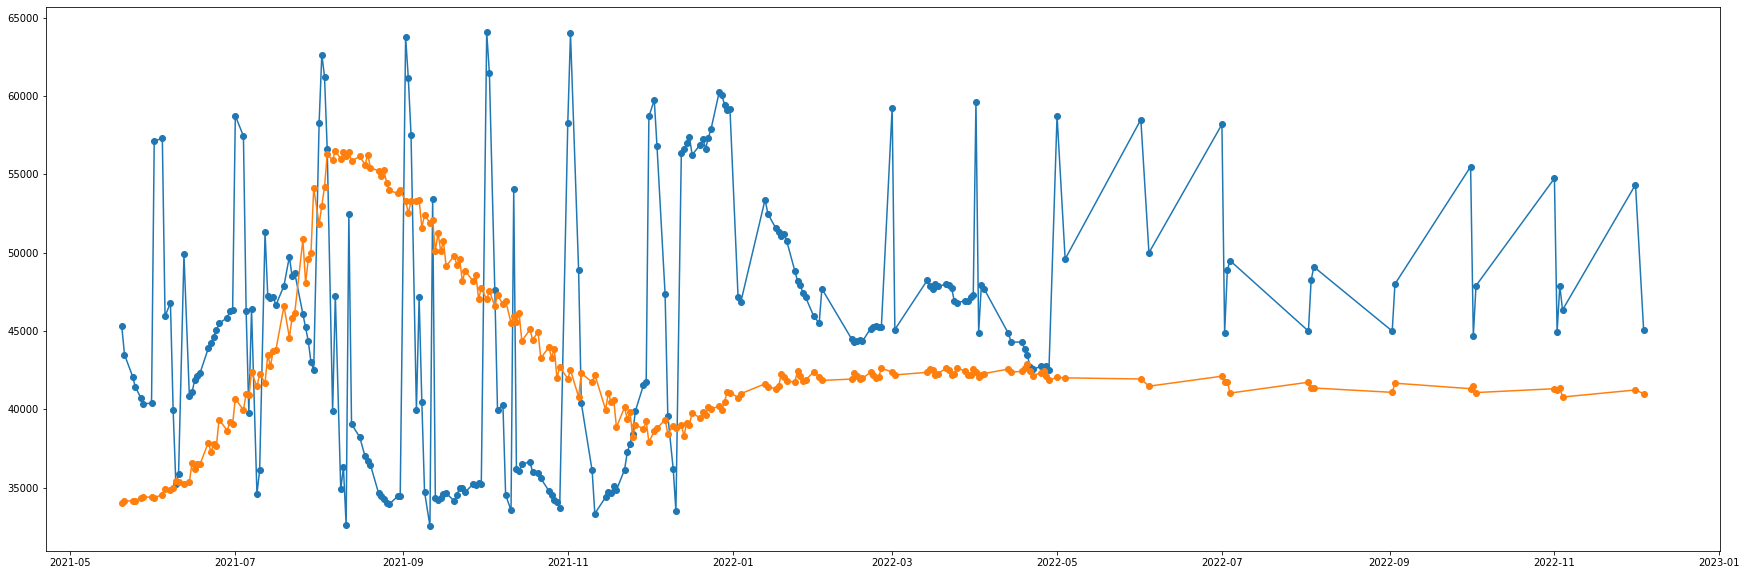

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_cabairawithijau_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabairawithijau2_a2 = pd.DataFrame()
data_new_cabairawithijau2_a2['actual'] = x_test
data_new_cabairawithijau2_a2['prediction'] = data_result2_a2
data_new_cabairawithijau2_a2.to_csv('cabairawithijau_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabairawithijau2_a2.actual, '-o')
plt.plot(y_test,data_new_cabairawithijau2_a2.prediction, '-o')
data_new_cabairawithijau2_a2